In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import csv

import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


from pitch_tracker.utils import files, dataset
import medleydb


/Users/tien.d/workspace/GITHUB/mono_pitch_tracker/medleydb/medleydb/__init__.py:69: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  INST_TAXONOMY = yaml.load(fhandle)
/Users/tien.d/workspace/GITHUB/mono_pitch_tracker/medleydb/medleydb/__init__.py:77: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  MIXING_COEFFICIENTS = yaml.load(fhandle)


In [3]:

hop_size = 512
step_frame = 2

DATASET_DIR = f'../content/pickled_database/{hop_size}_{step_frame}/'
DATA_SPLIT_PATH = '../pitch_tracker/utils/data_split.json'

SPLIT_BY_DIR = False
SPLIT_BY_ARTIST = True

# Ramdomly split by song name (dir)
if SPLIT_BY_DIR:
    dataset_paths = list(files.list_folder_paths_in_dir(DATASET_DIR))
    train_set, validation_set = train_test_split(dataset_paths, test_size=0.40, random_state=1, shuffle=True)
    validation_set, test_set = train_test_split(validation_set, test_size=0.50, random_state=1, shuffle=True)

# Split by artist, used in:
# https://github.com/dogacbasaran/ismir2018_dominant_melody_estimation/blob/master/random_dataset_splits/dataset-ismir-splits.json
# However the `AimeeNorwich_Child` file is broken so there's only 108/109 songs available
if SPLIT_BY_ARTIST:
    with open(DATA_SPLIT_PATH, 'r') as f:
        splits = json.load(f)
    train_set = [os.path.join(DATASET_DIR, song_name) for song_name in splits['train']]
    validation_set = [os.path.join(DATASET_DIR, song_name) for song_name in splits['validation']]
    test_set = [os.path.join(DATASET_DIR, song_name) for song_name in splits['test']]

# This ramdomize all the Pick Frames and create a splits where some samples
# from one song can be presents in train, validate and test.
else:
    dataset_paths = files.list_all_file_paths_in_dir(DATASET_DIR)
    train_set, validation_set = train_test_split(dataset_paths, test_size=0.40, random_state=1, shuffle=True)
    validation_set, test_set = train_test_split(validation_set, test_size=0.50, random_state=1, shuffle=True)

print(f'train_set: {len(train_set)}')
print(f'validation_set: {len(validation_set)}')
print(f'test_set: {len(test_set)}')

train_set: 66
validation_set: 15
test_set: 27


# Dataset distribution

In [4]:
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
%%capture

def parse_info_from_track_list(track_list:list):
    mtracks = medleydb.load_multitracks(track_list)
    tracks_info = []
    for mtrack in mtracks:
        track_id = mtrack.track_id
        predominant_instrument = mtrack.predominant_stem.instrument[0]
        genre = mtrack.genre
        duration = mtrack.duration
        intervals = {}
        with open(mtrack.melody_intervals_fpath, 'rU') as fhandle:
            linereader = csv.reader(fhandle, delimiter='\t')

            for line in linereader:
                stem_idx = int(line[2])
                stem_instrument = mtrack.stems[stem_idx].instrument[0]
                if stem_instrument not in intervals:
                    intervals[stem_instrument] = 1
                else:
                    intervals[stem_instrument]+=1
        melody2_instruments = [key for key in intervals]
        tracks_info.append((track_id, predominant_instrument, melody2_instruments, genre, duration))
    return tracks_info

train_tracks_info = parse_info_from_track_list(splits['train'])
validation_tracks_info = parse_info_from_track_list(splits['validation'])
test_tracks_info = parse_info_from_track_list(splits['test'])


In [6]:
columns=['track_id', 'predominant_instrument', 'melody2_instruments', 'genre', 'duration']
train_df = pd.DataFrame(train_tracks_info, columns=columns)
validation_df = pd.DataFrame(validation_tracks_info, columns=columns)
test_df = pd.DataFrame(test_tracks_info, columns=columns)

## Genres

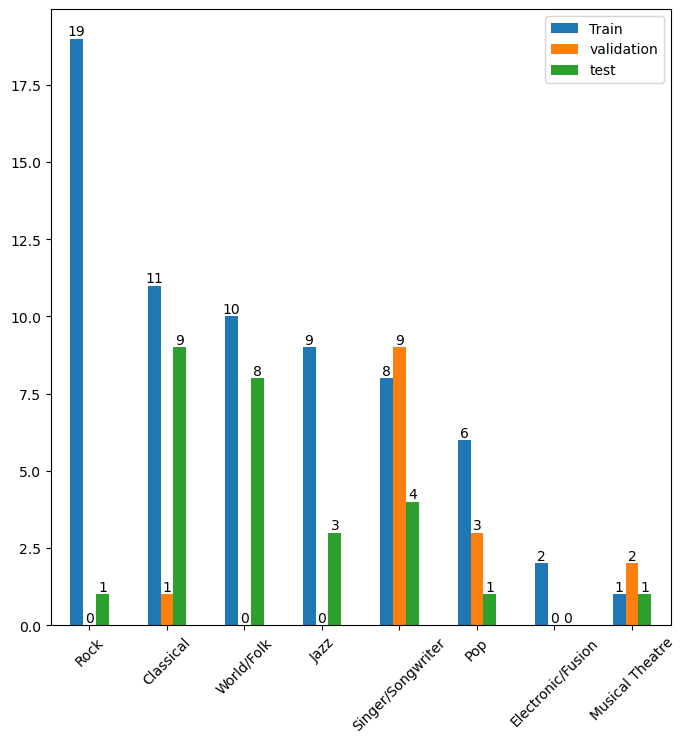

In [7]:
def plot_bars(dfs, figsize=(8, 8)):
    df = pd.concat(dfs, axis=1)
    fig, ax = plt.subplots(figsize=figsize)
    df.plot.bar(rot=45, ax=ax)
    for i in ax.containers:
        ax.bar_label(i)
    plt.show()

series = []
s = train_df['genre'].value_counts()
s.name = "Train"
series.append(s)
s = validation_df['genre'].value_counts()
s.name = "validation"
series.append(s)
s = test_df['genre'].value_counts()
s.name = "test"
series.append(s)

plot_bars(series) 

## Duration

In [20]:
train_df

,track_id,predominant_instrument,melody2_instruments,genre,duration
0,AimeeNorwich_Flying,clean electric guitar,"[clean electric guitar, clarinet]",World/Folk,217.803129
1,AlexanderRoss_GoodbyeBolero,male singer,"[harmonica, male singer, brass section, clean ...",Singer/Songwriter,418.816757
2,AlexanderRoss_VelvetCurtain,male singer,"[male singer, brass section, string section, a...",Singer/Songwriter,514.488231
3,AvaLuna_Waterduct,male singer,[male singer],Rock,259.305170
4,BigTroubles_Phantom,male singer,"[male singer, distorted electric guitar]",Rock,146.935873
...,...,...,...,...,...
61,SweetLights_YouLetMeDown,male singer,"[vocalists, male singer]",Pop,391.981859
62,TheDistricts_Vermont,male singer,"[clean electric guitar, male singer]",Rock,228.152993
63,TheScarletBrand_LesFleursDuMal,male singer,"[male singer, distorted electric guitar]",Rock,303.637347
64,TheSoSoGlos_Emergency,male singer,"[distorted electric guitar, male singer]",Rock,167.000000


# Dataset & dataloader

In [8]:
train_dataset = dataset.AudioDataset(train_set)
validation_set = dataset.AudioDataset(validation_set)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_set, batch_size=8, shuffle=True)

In [9]:
feature, label = next(iter(train_dataloader))

In [10]:
print(feature.shape)

torch.Size([8, 1, 420, 88])
